In [1]:
import numpy as Math
import pylab as Plot

In [2]:
def Hbeta(D = Math.array([]), beta = 1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;

In [3]:
def x2p(X = Math.array([]), tol = 1e-5, perplexity = 30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print "Computing pairwise distances..."
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print "Computing P-values for point ", i, " of ", n, "..."

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax =  Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy();
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i].copy();
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i+1:n]))] = thisP;

    # Return final P-matrix
    print "Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta));
    return P;

In [4]:
def pca(X = Math.array([]), no_dims = 50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print "Preprocessing the data using PCA..."
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:,0:no_dims]);
    return Y;

In [5]:
def tsne(X = Math.array([]), no_dims = 2, initial_dims = 50, perplexity = 30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if isinstance(no_dims, float):
        print "Error: array X should have type float.";
        return -1;
    if round(no_dims) != no_dims:
        print "Error: number of dimensions should be an integer.";
        return -1;

    # Initialize variables
    X = pca(X, initial_dims).real;
    (n, d) = X.shape;
    max_iter = 1000;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;                                    # early exaggeration
    P = Math.maximum(P, 1e-12);

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);

        # Compute gradient
        PQ = P - Q;
        for i in range(n):
            dY[i,:] = Math.sum(Math.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0);

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = Math.sum(P * Math.log(P / Q));
            print "Iteration ", (iter + 1), ": error is ", C

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;

    # Return solution
    return Y;

Lowest kl_divergence: 0.299940019846


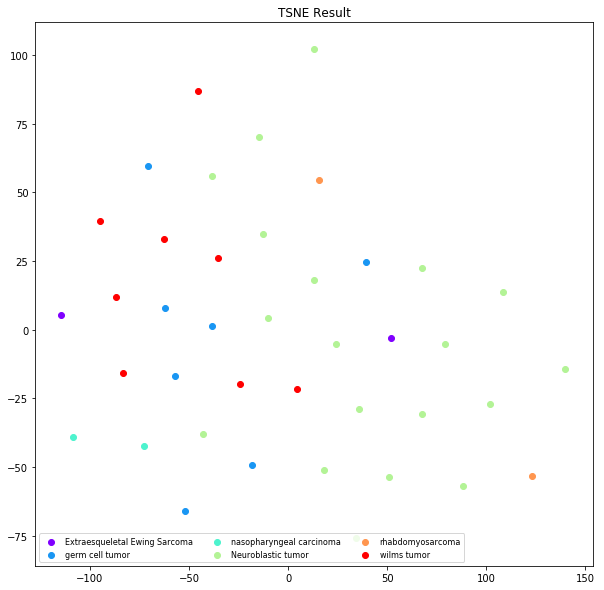

In [6]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import sys

plt.rcParams['figure.figsize'] = 10, 10

# sklearn tsne
X = Math.loadtxt("input/x_rodrigo_teste.txt");
labels = Math.loadtxt("input/label_rodrigo_teste.txt");

last_divergence = sys.maxint
X_embedded = None
for i in range(0,25):
    my_tse = TSNE(n_components=2)
    cur_X_embedded = my_tse.fit_transform(X)
    if last_divergence >= my_tse.kl_divergence_:
        X_embedded = cur_X_embedded
        last_divergence = my_tse.kl_divergence_
        
print 'Lowest kl_divergence: ' + str(last_divergence)

color_legends = {1: 'Extraesqueletal Ewing Sarcoma',
                 2: 'germ cell tumor',
                 3: 'nasopharyngeal carcinoma',
                 4: 'Neuroblastic tumor',
                 5: 'rhabdomyosarcoma',
                 6: 'wilms tumor'}
raibow = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
labels_array = []
legends_array = []

for i in range(0, len(labels)):
    labels_array.append(raibow[int(labels[i]) - 1])
    legends_array.append(color_legends[int(labels[i])])

scater_for_legend = []
last_color_id = labels[0]

for i in range(0, len(X_embedded)):
    if last_color_id != labels[i] or i==0:
        plt.scatter(X_embedded[i][0], X_embedded[i][1], color = labels_array[i], label = color_legends[int(labels[i])])
    else :
        plt.scatter(X_embedded[i][0], X_embedded[i][1], color = labels_array[i])
        
    last_color_id = labels[i]

plt.title('TSNE Result')
plt.legend(scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)
plt.show()


Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  2500 ...
Computing P-values for point  500  of  2500 ...
Computing P-values for point  1000  of  2500 ...
Computing P-values for point  1500  of  2500 ...
Computing P-values for point  2000  of  2500 ...
Mean value of sigma:  1.0365357498
Iteration  10 : error is  23.9093729763
Iteration  20 : error is  21.554160923
Iteration  30 : error is  18.4771569067
Iteration  40 : error is  17.2738342727
Iteration  50 : error is  16.8720474952
Iteration  60 : error is  16.6965743178
Iteration  70 : error is  16.5742521206
Iteration  80 : error is  16.4957244748
Iteration  90 : error is  16.4226550358
Iteration  100 : error is  16.3291730011
Iteration  110 : error is  2.42427349996
Iteration  120 : error is  2.13188612988
Iteration  130 : error is  1.92645990986
Iteration  140 :

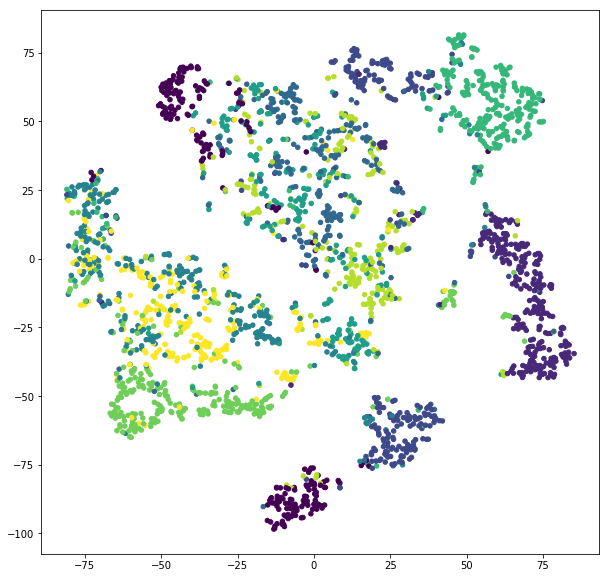

In [7]:
print "Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset."
print "Running example on 2,500 MNIST digits..."
X = Math.loadtxt("input/mnist2500_X.txt");
labels = Math.loadtxt("input/mnist2500_labels.txt");
Y = tsne(X, 2, 5, 20.0);
Plot.scatter(Y[:,0], Y[:,1], 20, labels);
Plot.show();

Lowest kl_divergence: 1.1476585865


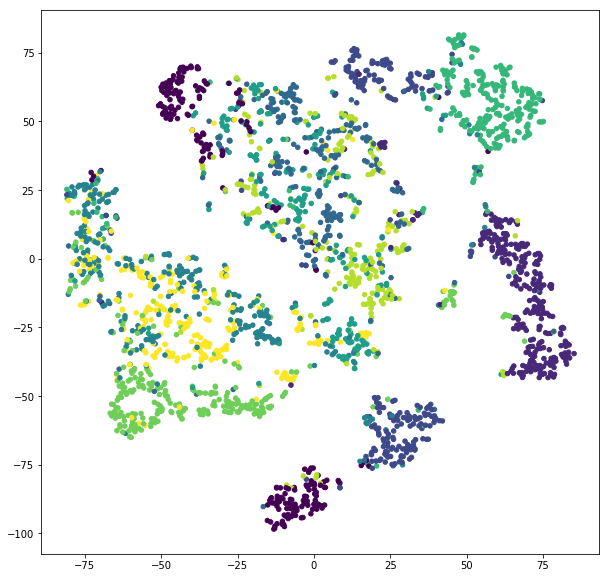

In [9]:
# sklearn tsne
X = Math.loadtxt("input/mnist2500_X.txt");
labels = Math.loadtxt("input/mnist2500_labels.txt");

last_divergence = sys.maxint
X_embedded = None
#for i in range(0,25):
my_tse = TSNE(n_components=2)
cur_X_embedded = my_tse.fit_transform(X)
if last_divergence >= my_tse.kl_divergence_:
    X_embedded = cur_X_embedded
    last_divergence = my_tse.kl_divergence_
        
print 'Lowest kl_divergence: ' + str(last_divergence)
Plot.scatter(Y[:,0], Y[:,1], 20, labels);
Plot.show();

In [13]:
import sklearn.datasets

X, color = datasets.samples_generator.make_blobs(n_samples=1000, centers=3, n_features=80, random_state=0)

my_tse = TSNE(n_components=2)
cur_X_embedded = my_tse.fit_transform(X)
if last_divergence >= my_tse.kl_divergence_:
    X_embedded = cur_X_embedded
    last_divergence = my_tse.kl_divergence_
        
print 'Lowest kl_divergence: ' + str(last_divergence)
Plot.scatter(cur_X_embedded[:,0], cur_X_embedded[:,1], label = color, cmap=plt.cm.Spectral);
Plot.show();

NameError: name 'datasets' is not defined

Lowest kl_divergence: 0.247331917286


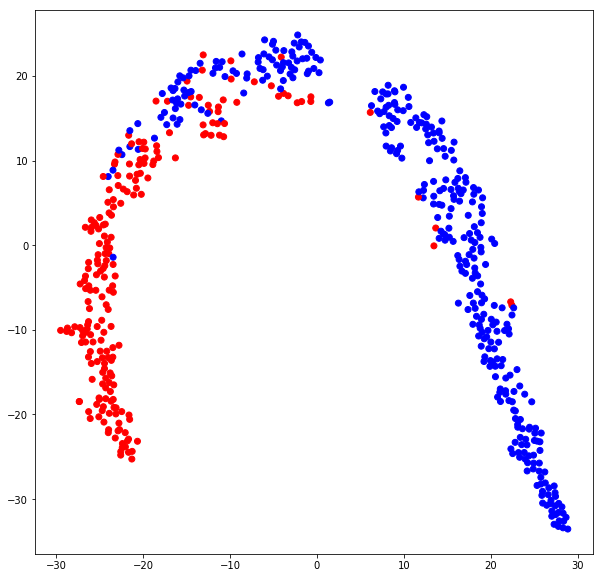

In [12]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, color = data['data'], data['target'] 


last_divergence = sys.maxint
X_embedded = None
for i in range(0,25):
    my_tse = TSNE(n_components=2)
    cur_X_embedded = my_tse.fit_transform(X)
    if last_divergence >= my_tse.kl_divergence_:
        X_embedded = cur_X_embedded
        last_divergence = my_tse.kl_divergence_
        
print 'Lowest kl_divergence: ' + str(last_divergence)

names = data['target_names']
colors_map = []
for c in color:
    if c == 0:
        colors_map.append('red')
    else:
        colors_map.append('blue')

Plot.scatter(cur_X_embedded[:,0], cur_X_embedded[:,1], label = color, color = colors_map);
Plot.show();